In [1]:
import pandas as pd
train_dataset = pd.read_csv('corpus-raymond/train-full-hf-style.csv')
val_dataset = pd.read_csv('corpus-raymond/val-full-hf-style.csv')
test_dataset = pd.read_csv('corpus-raymond/test-full-hf-style.csv')
#take column 'tokens' as list
train_dataset['tokens'] = train_dataset['tokens'].apply(eval)
val_dataset['tokens'] = val_dataset['tokens'].apply(eval)
test_dataset['tokens'] = test_dataset['tokens'].apply(eval)

#take column 'IOB_tag' as list
train_dataset['IOB_tag'] = train_dataset['IOB_tag'].apply(eval)
val_dataset['IOB_tag'] = val_dataset['IOB_tag'].apply(eval)
test_dataset['IOB_tag'] = test_dataset['IOB_tag'].apply(eval)


In [2]:
!python --version

Python 3.11.11


In [3]:
iob_mapping = {
    "O": 0,
    "B-class": 1,
    "I-class": 2,
    "B-attr": 3,
    "I-attr": 4
}

label_names = [ 'O', 'B-class', 'I-class', 'B-attr', 'I-attr' ]

In [4]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}
id2label[5] = "[PAD]"
label2id["[PAD]"] = 5
print(id2label)
print(label2id)

{0: 'O', 1: 'B-class', 2: 'I-class', 3: 'B-attr', 4: 'I-attr', 5: '[PAD]'}
{'O': 0, 'B-class': 1, 'I-class': 2, 'B-attr': 3, 'I-attr': 4, '[PAD]': 5}


In [5]:
words = train_dataset.iloc[0]["tokens"]
labels = train_dataset.iloc[0]["IOB_tag"]
line1 = ""
line2 = ""
for word, label in zip(words, labels):
    full_label = label_names[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)

. HTTPS with browser web button account customer new sdram MB 128 ; chip ram Flash ; GB : requirement hardware follow the to adhere 4 Intel XScale PXA270 a Register 
O O     O    O       O   O      I-class B-class  O   O     O  O   O O    O   O     O O  O O           O        O      O   O  O      O O     O      O      O O        


In [6]:
from transformers import AutoTokenizer, DebertaV2TokenizerFast
import os
from pathlib import Path
tokenizer_checkpoint = "FacebookAI/xlm-roberta-large"
model_checkpoint = "FacebookAI/xlm-roberta-large" 
folder_name = "BERT-Style-result/FacebookAI/xlm-roberta-large-4-epoch-8-bs"
model_name_save = "BERT-Style-model/FacebookAI/xlm-roberta-large-4-epoch-8-bs"
Path(folder_name).mkdir(parents=True, exist_ok=True)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_checkpoint, add_prefix_space=True )

max_length = 256
epochs = 4
bs = 8

In [7]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = 5 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(5)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

In [8]:
inputs = tokenizer(train_dataset.iloc[0]["tokens"],truncation=True, is_split_into_words=True, padding='do_not_pad', max_length=max_length)
labels = train_dataset.iloc[0]["IOB_tag"]
word_ids = inputs.word_ids()
print(inputs)
print(labels)
print(align_labels_with_tokens(labels, word_ids))

{'input_ids': [0, 6, 5, 135913, 294, 678, 31842, 1467, 77679, 15426, 43373, 3525, 91, 3041, 39, 12918, 26560, 2819, 59420, 13969, 28750, 2819, 20331, 152, 64209, 674, 76407, 28960, 70, 47, 606, 35593, 201, 24018, 112720, 57965, 436, 65415, 104283, 10, 131423, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
[0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[5, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5]


In [9]:
def tokenize_and_align_labels(df):
    # Convert Pandas DataFrame to dictionary format (column-based)
    examples = df.to_dict(orient="list")

    # Tokenize the input tokens
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True, padding='max_length', max_length=max_length
    )

    all_labels = examples["IOB_tag"]
    rearranged_labels = []

    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        rearranged_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = rearranged_labels
    return tokenized_inputs


In [10]:
tokenized_train = tokenize_and_align_labels(train_dataset)
tokenized_val = tokenize_and_align_labels(val_dataset)
tokenized_test = tokenize_and_align_labels(test_dataset)

In [11]:
from datasets import Dataset
# convert tokenized train to arrow dataset class
train_dataset = Dataset.from_dict(tokenized_train)
val_dataset = Dataset.from_dict(tokenized_val)
test_dataset = Dataset.from_dict(tokenized_test)

# Data Collation

In [12]:
# from transformers import DataCollatorForTokenClassification

# data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# Metrics

In [13]:
import evaluate

metric = evaluate.load("seqeval")

In [14]:
import numpy as np


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

# Defining the model

In [15]:
from torch.optim import AdamW
from transformers import AutoModelForTokenClassification,AutoModelForSeq2SeqLM

model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
    num_labels=len(id2label),
)
# weight_decay is a regularization procedure with regard to the weight matrices
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

# Adam optimizer
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = "cuda"
print(device)
model.to(device)

cuda


XLMRobertaForTokenClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, out_f

# Preparing Fine Tuning

In [17]:
# Convert the dataset to torch tensors
train_inputs = torch.tensor(train_dataset["input_ids"])
dev_inputs = torch.tensor(val_dataset["input_ids"])
test_inputs = torch.tensor(test_dataset["input_ids"])
train_tags = torch.tensor(train_dataset["labels"])
dev_tags = torch.tensor(val_dataset["labels"])
test_tags = torch.tensor(test_dataset["labels"])
train_masks = torch.tensor(train_dataset["attention_mask"])
dev_masks = torch.tensor(val_dataset["attention_mask"])
test_masks = torch.tensor(test_dataset["attention_mask"])

In [18]:
from torch.utils.data import TensorDataset, RandomSampler, DataLoader, SequentialSampler

# We define the dataloaders. 
# Shuffle the data for training using RandomSampler
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

# Load dev and test data sequentially with SequentialSampler.
dev_data = TensorDataset(dev_inputs, dev_masks, dev_tags)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=bs)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

In [19]:
# Import a scheduler to reduce the learning rate 
from transformers import get_linear_schedule_with_warmup

# Number of training epochs; the BERT paper uses 10
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Training

In [20]:
from sklearn.metrics import f1_score
from tqdm import trange

# To measure execution time of this cell

# Train the model for; the BERT paper uses 4
## Store the average loss after each epoch; these values are used to plot the loss.
loss_values, development_loss_values = [], []


for _ in trange(epochs, desc="Epoch"):
    #
    # Training
    #
    # Set the model into training mode
    model.train()
    # Reset the total loss for each epoch
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        # Transfer batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Remove previous gradients before each backward pass
        model.zero_grad()
        # forward pass
        # This returns the loss (not the model output) since we have input the labels.
        outputs = model(b_input_ids,
                        attention_mask=b_input_mask, labels=b_labels)
        # Get the loss
        loss = outputs[0]
        # Backward pass to compute the gradients
        loss.backward()
        # Train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # Update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    

    # Store each loss value for plotting the learning curve afterwards
    loss_values.append(avg_train_loss)

    # After each training epoch, measure performance on development set

    # Set the model into evaluation mode
    model.eval()
    # Reset the development loss for this epoch
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in dev_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # The model must not compute or save gradients, in order to save memory and speed up this step
        with torch.no_grad():
            # Forward pass, compute predictions
            # This will return the logits (logarithm of the odds), not the loss (we do not provide labels)
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # Transfer logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Compute the accuracy for this batch of development sentences
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)
        
        #data_seqeval["batch"].append(str(batch))
        #data_seqeval["true_tags"].append(str(label_ids))
        #data_seqeval["predicted_tags"].append(str([list(p) for p in np.argmax(logits, axis=2)]))

    #df_seqeval = pd.DataFrame(data_seqeval)
    #wandb.log({f"dataframe_seqeval": wandb.Table(dataframe=df_seqeval)})
    
    eval_loss = eval_loss / len(dev_dataloader)
    development_loss_values.append(eval_loss)
    print("Development loss: {}".format(eval_loss))
    pred_tags = [id2label[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if id2label[l_i] != "[PAD]"]
    dev_tags = [id2label[l_i] for l in true_labels
                                  for l_i in l if id2label[l_i] != "[PAD]"]
    f1 = f1_score(pred_tags, dev_tags, average='micro')

    # Format output with 4 decimal places
    output_text = "train-val F1 score: {:.4f}\n".format(f1)

    # Print to console
    print(output_text)

    # Save to a text file
    with open(folder_name + "/f1_score.txt", "a") as file:
        file.write(output_text)
    #print("Development classification report:\n{}".format(classification_report(pred_tags, dev_tags,digits=4)))
    print()
    

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Average train loss: 0.09568832854121706


Epoch:  25%|██▌       | 1/4 [02:11<06:33, 131.18s/it]

Development loss: 0.05015460648810712
train-val F1 score: 0.8813


Average train loss: 0.03959833800853876


Epoch:  50%|█████     | 2/4 [04:36<04:39, 139.70s/it]

Development loss: 0.03904691122282865
train-val F1 score: 0.8849


Average train loss: 0.028375046453472687


Epoch:  75%|███████▌  | 3/4 [07:02<02:22, 142.56s/it]

Development loss: 0.0362882939940792
train-val F1 score: 0.8982


Average train loss: 0.02092305541354619


Epoch: 100%|██████████| 4/4 [09:28<00:00, 142.17s/it]

Development loss: 0.038332554022386923
train-val F1 score: 0.8998




In [21]:
df = pd.DataFrame(list(zip(pred_tags, dev_tags)),
               columns =['Pred', 'True'])
df.to_csv(folder_name + '/train-val-result-bert.csv')

# Visualize

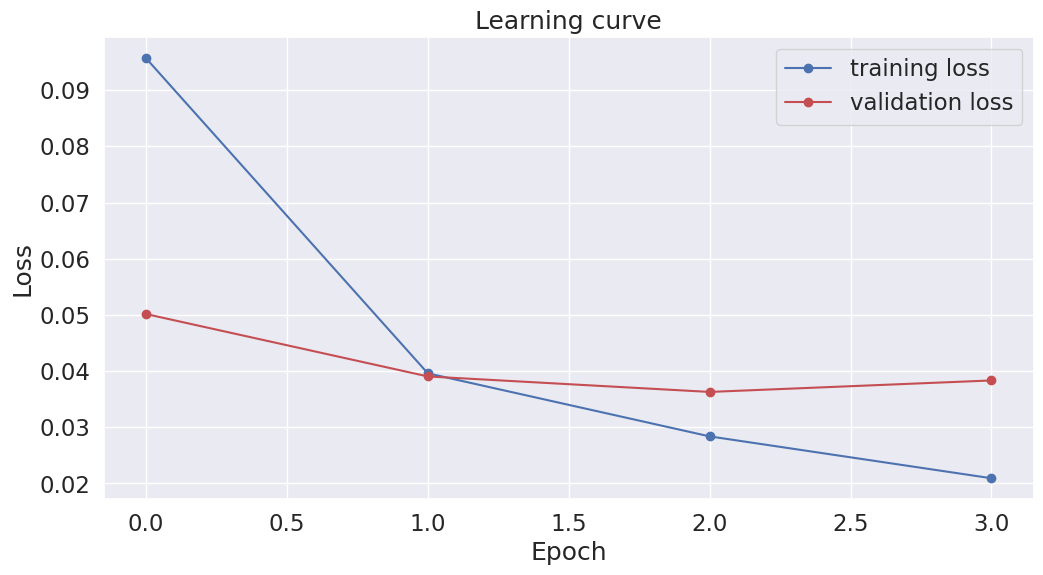

In [22]:
# Plot the training loss
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(development_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# Testing  

In [23]:
# Apply the model to the test set
# Set again the model into evaluation mode
model.eval()
nb_eval_steps, nb_eval_examples = 0, 0
predictions , true_labels = [], []

input_ids_list = []

for batch in test_dataloader:

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    # The model must not compute or store gradients
    with torch.no_grad():
        # Forward pass, calculate predictions.
        outputs = model(b_input_ids,
                            attention_mask=b_input_mask, labels=b_labels)
    # Transfer logits and labels to CPU
    logits = outputs[1].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    input_ids_list.extend(b_input_ids)
    
    # Calculate the accuracy for this batch of test sentences
    eval_loss += outputs[0].mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

pred_tags = [id2label[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if id2label[l_i] != "[PAD]"]
test_tags = [id2label[l_i] for l in true_labels
                                  for l_i in l if id2label[l_i] != "[PAD]"]
#print(str(pred_tags))
#print(str(test_tags))
f1 = f1_score(pred_tags, test_tags, average='micro')

# Format output with 4 decimal places
output_text = "Test F1 score: {:.4f}\n".format(f1)

# Print to console
print(output_text)

# Save to a text file
with open(folder_name + "/f1_score.txt", "a") as file:
    file.write(output_text)
#print("Test classification report: {}".format(classification_report(pred_tags, test_tags,digits=4)))

print()

Test F1 score: 0.8749




In [24]:
df = pd.DataFrame(list(zip(pred_tags, test_tags)),
               columns =['Pred', 'True'])
df.to_csv(folder_name + '/test-result-bert.csv')

In [25]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Load the CSV file
df = pd.read_csv(folder_name+"/test-result-bert.csv")

# Extract true and predicted labels
y_true = df["True"]
y_pred = df["Pred"]

# Define the target classes
target_classes = ["B-class", "I-class", "B-attr", "I-attr", "O"]

# Compute precision, recall, and F1-score for the specified classes
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=target_classes, zero_division=0)

# Compute overall accuracy
accuracy = accuracy_score(y_true, y_pred)

# Create a results dictionary
metrics = pd.DataFrame({
    "Class": target_classes,
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
})

# Add overall accuracy
metrics.loc[len(metrics)] = ["Overall Accuracy", accuracy, accuracy, accuracy]

# Save metrics to a text file
with open(folder_name + "/f1_score.txt", "a") as file:
    file.write(metrics.to_string(index=False) + "\n")

# Display results
print(metrics)


              Class  Precision    Recall  F1-Score
0           B-class   0.619247  0.688372  0.651982
1           I-class   0.517730  0.474026  0.494915
2            B-attr   0.701613  0.621429  0.659091
3            I-attr   0.810606  0.575269  0.672956
4                 O   0.928114  0.949192  0.938535
5  Overall Accuracy   0.874886  0.874886  0.874886


# Saving

In [26]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
roberta.embeddings.word_embeddings.weight 	 torch.Size([250002, 1024])
roberta.embeddings.position_embeddings.weight 	 torch.Size([514, 1024])
roberta.embeddings.token_type_embeddings.weight 	 torch.Size([1, 1024])
roberta.embeddings.LayerNorm.weight 	 torch.Size([1024])
roberta.embeddings.LayerNorm.bias 	 torch.Size([1024])
roberta.encoder.layer.0.attention.self.query.weight 	 torch.Size([1024, 1024])
roberta.encoder.layer.0.attention.self.query.bias 	 torch.Size([1024])
roberta.encoder.layer.0.attention.self.key.weight 	 torch.Size([1024, 1024])
roberta.encoder.layer.0.attention.self.key.bias 	 torch.Size([1024])
roberta.encoder.layer.0.attention.self.value.weight 	 torch.Size([1024, 1024])
roberta.encoder.layer.0.attention.self.value.bias 	 torch.Size([1024])
roberta.encoder.layer.0.attention.output.dense.weight 	 torch.Size([1024, 1024])
roberta.encoder.layer.0.attention.output.dense.bias 	 torch.Size([1024])
roberta.encoder.layer.0.attention.output.LayerNorm.we

In [27]:
model.save_pretrained(model_name_save)
tokenizer.save_pretrained(model_name_save)

('BERT-Style-model/FacebookAI/xlm-roberta-large-4-epoch-8-bs/tokenizer_config.json',
 'BERT-Style-model/FacebookAI/xlm-roberta-large-4-epoch-8-bs/special_tokens_map.json',
 'BERT-Style-model/FacebookAI/xlm-roberta-large-4-epoch-8-bs/sentencepiece.bpe.model',
 'BERT-Style-model/FacebookAI/xlm-roberta-large-4-epoch-8-bs/added_tokens.json',
 'BERT-Style-model/FacebookAI/xlm-roberta-large-4-epoch-8-bs/tokenizer.json')